In [11]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("EDA").getOrCreate()
tripdata_df = spark.read.parquet("gs://msca-bdp-student-gcs/Group_8/tripdata_cleaned", header=True, inferSchema=True)

In [12]:
tripdata_df.printSchema()
tripdata_df.show()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- request_datetime: timestamp (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: integer (nullable = true)
 |-- shared_match_flag: integer (nullable = true)
 |-- access_a_ride_flag: integer (nullable = true)
 |-- wav_request_flag: integer (nullable = true)
 |-- wait_time: long (nullable = true)
 |-- request_time_of_day: string (nullable = true)
 |-- request_hour: integer (nullable = 

+-----------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+----+----------+-------------------+-----------------+------------------+----------------+---------+-------------------+------------+-------------------+-------------+------------------+-----------+------------------+------------+
|hvfhs_license_num|   request_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|tips|driver_pay|shared_request_flag|shared_match_flag|access_a_ride_flag|wav_request_flag|wait_time|request_time_of_day|request_hour|request_day_of_week|request_month|pickup_time_of_day|pickup_hour|pickup_day_of_week|pickup_month|
+-----------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+-----

In [3]:
percent_missing_a = 100 * (1 - (tripdata_df.select("wav_match_flag").dropna().count() / tripdata_df.select("wav_match_flag").count()))
print(percent_missing_a)

0.0


In [3]:
grouped_sorted_df = tripdata_df.groupBy("PULocationID").count().orderBy("count", ascending=False)

# Show the result
grouped_sorted_df.show()  # Adjust the number of rows as needed

+------------+--------+
|PULocationID|   count|
+------------+--------+
|          61|11099416|
|          79|11095383|
|         138|10739311|
|         132|10356646|
|          37| 8549796|
|         231| 8427494|
|         234| 8341777|
|          76| 8207722|
|         161| 8064925|
|         230| 7967801|
|          68| 7904938|
|          48| 7746582|
|         148| 7676633|
|         255| 7396355|
|         246| 7369920|
|         170| 7333708|
|          42| 7288094|
|           7| 7286068|
|         164| 7269143|
|         181| 7063462|
+------------+--------+
only showing top 20 rows



In [13]:
from pyspark.sql.functions import when, col

# Mapping of codes to company names
code_to_company = {
    "HV0002": "Juno",
    "HV0003": "Uber",
    "HV0004": "Via",
    "HV0005": "Lyft"
}

# Initialize the column expression with a default value (here we use the existing column value)
column_expr = col("hvfhs_license_num")

# Chain when clauses for each mapping
for code, company in code_to_company.items():
    column_expr = when(col("hvfhs_license_num") == code, company).otherwise(column_expr)

# Apply the transformation to create the new "company" column
tripdata_df = tripdata_df.withColumn("company", column_expr)

# Show some rows to verify the change
tripdata_df.show()


+-----------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+----+----------+-------------------+-----------------+------------------+----------------+---------+-------------------+------------+-------------------+-------------+------------------+-----------+------------------+------------+-------+
|hvfhs_license_num|   request_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|tips|driver_pay|shared_request_flag|shared_match_flag|access_a_ride_flag|wav_request_flag|wait_time|request_time_of_day|request_hour|request_day_of_week|request_month|pickup_time_of_day|pickup_hour|pickup_day_of_week|pickup_month|company|
+-----------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+

In [4]:
tripdata_df = tripdata_df.drop("request_datetime", "pickup_datetime")
tripdata_df.printSchema()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: integer (nullable = true)
 |-- shared_match_flag: integer (nullable = true)
 |-- access_a_ride_flag: integer (nullable = true)
 |-- wav_request_flag: integer (nullable = true)
 |-- wait_time: long (nullable = true)
 |-- request_time_of_day: string (nullable = true)
 |-- request_hour: integer (nullable = true)
 |-- request_day_of_week: integer (nullable = true)
 |-- request_month: integer (nullable = tru

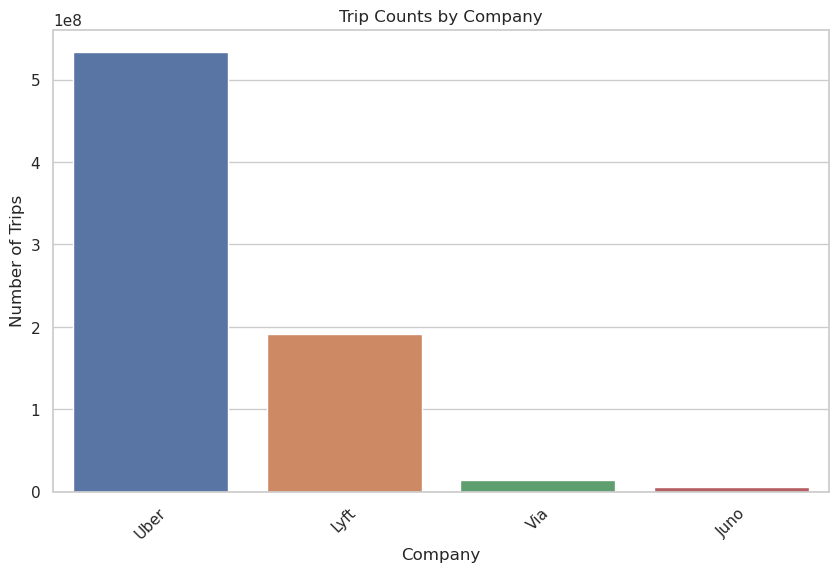

In [5]:
#Trip Counts by Company:

from pyspark.sql import functions as F

# Group by 'company' and count trips
trip_counts_by_company = tripdata_df.groupBy("company").agg(F.count("*").alias("trip_count"))

# Convert to Pandas DataFrame for visualization
pandas_trip_counts = trip_counts_by_company.toPandas()
sorted_pandas_trip_counts = pandas_trip_counts.sort_values(by="trip_count", ascending=False)








import matplotlib.pyplot as plt
import seaborn as sns

# Set the visualization style
sns.set(style="whitegrid")

# Bar plot for trip counts by company
plt.figure(figsize=(10, 6))
sns.barplot(x="company", y="trip_count", data=sorted_pandas_trip_counts)
plt.title("Trip Counts by Company")
plt.xlabel("Company")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45)
plt.show()



<Figure size 1200x600 with 0 Axes>

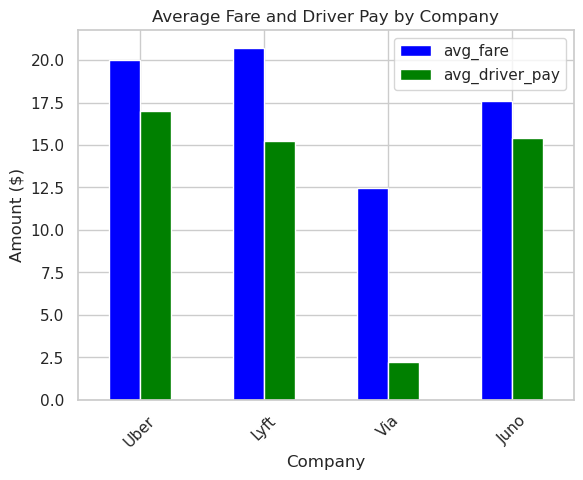

In [17]:

#Average Fares and Driver Pay by Company
# Group by 'company' and calculate averages
avg_prices_by_company = tripdata_df.groupBy("company").agg(
    F.avg("base_passenger_fare").alias("avg_fare"),
    F.avg("driver_pay").alias("avg_driver_pay")
)

# Convert to Pandas DataFrame
pandas_avg_prices = avg_prices_by_company.toPandas()

pandas_avg_prices.set_index('company', inplace=True)

# Reindex the DataFrame with the specified order
new_order = ['Uber', 'Lyft', 'Via', 'Juno']
pandas_avg_prices = pandas_avg_prices.reindex(new_order)

# Reset the index for plotting
pandas_avg_prices.reset_index(inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
pandas_avg_prices.plot(x='company', kind='bar', stacked=False, color=['blue', 'green'])
plt.title('Average Fare and Driver Pay by Company', fontsize=12)
plt.ylabel('Amount ($)', fontsize=12)
plt.xlabel('Company', fontsize=12)
plt.xticks(rotation=45)
plt.show()


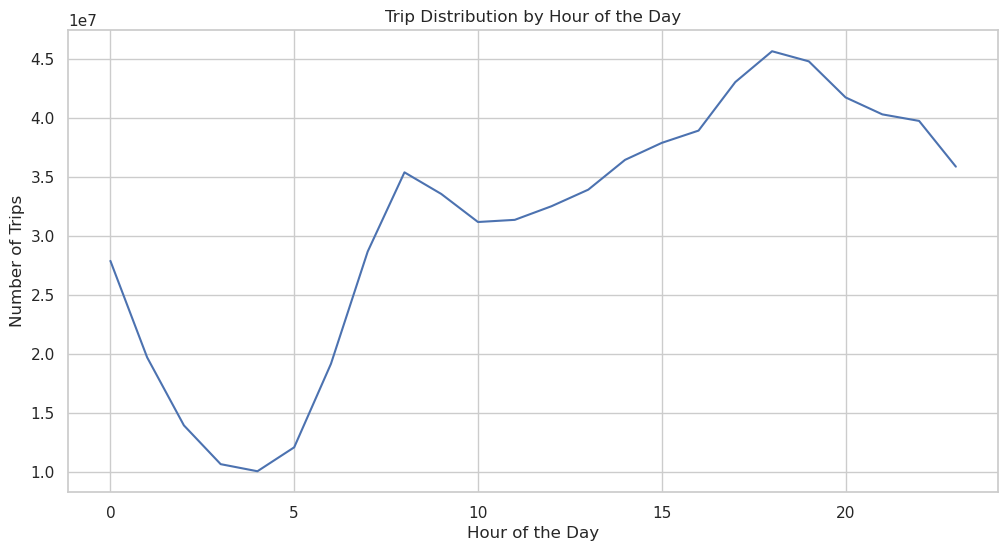

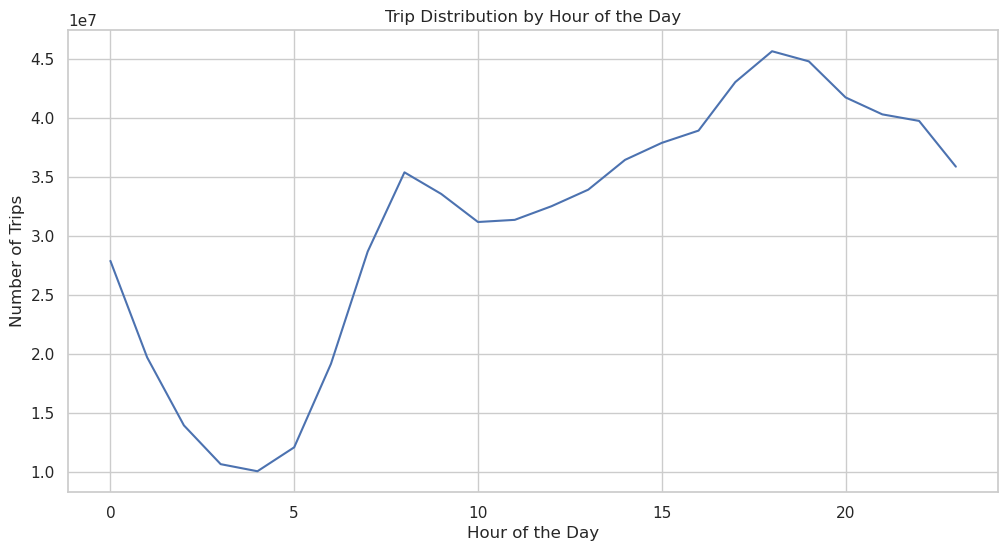

In [11]:
#Trip Distribution by Hour



# Group by 'pickup_hour' and count trips
trip_distribution_hour = tripdata_df.groupBy("pickup_hour").agg(F.count("*").alias("trip_count"))

# Convert to Pandas DataFrame
pandas_trip_distribution_hour = trip_distribution_hour.toPandas()


# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=pandas_trip_distribution_hour, x='pickup_hour', y='trip_count')
plt.title('Trip Distribution by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.show()





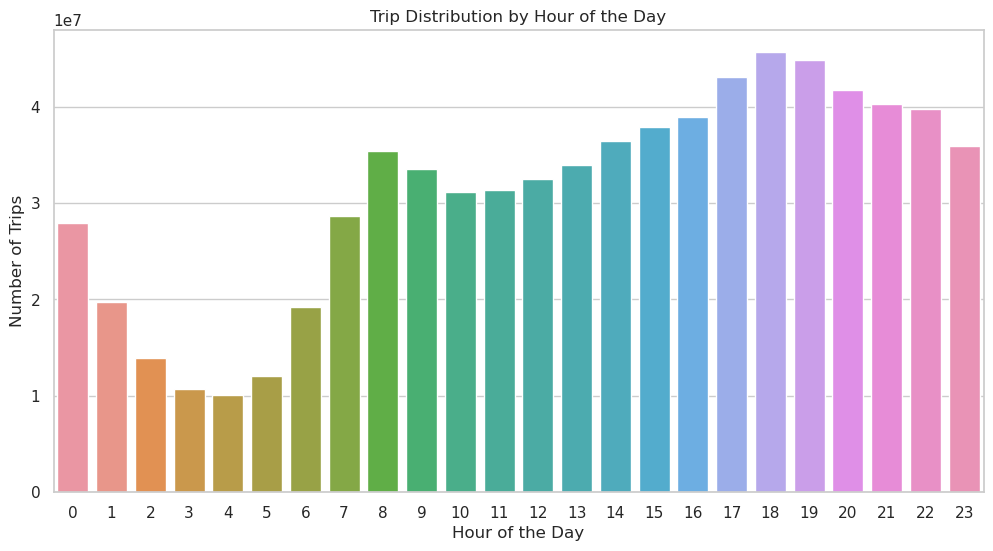

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns



# Group by 'pickup_hour' and count trips
trip_distribution_hour = tripdata_df.groupBy("pickup_hour").agg(F.count("*").alias("trip_count"))

# Convert to Pandas DataFrame
pandas_trip_distribution_hour = trip_distribution_hour.toPandas()

# Assuming you have already created pandas_trip_distribution_hour DataFrame as before

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=pandas_trip_distribution_hour, x='pickup_hour', y='trip_count')
plt.title('Trip Distribution by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.show()


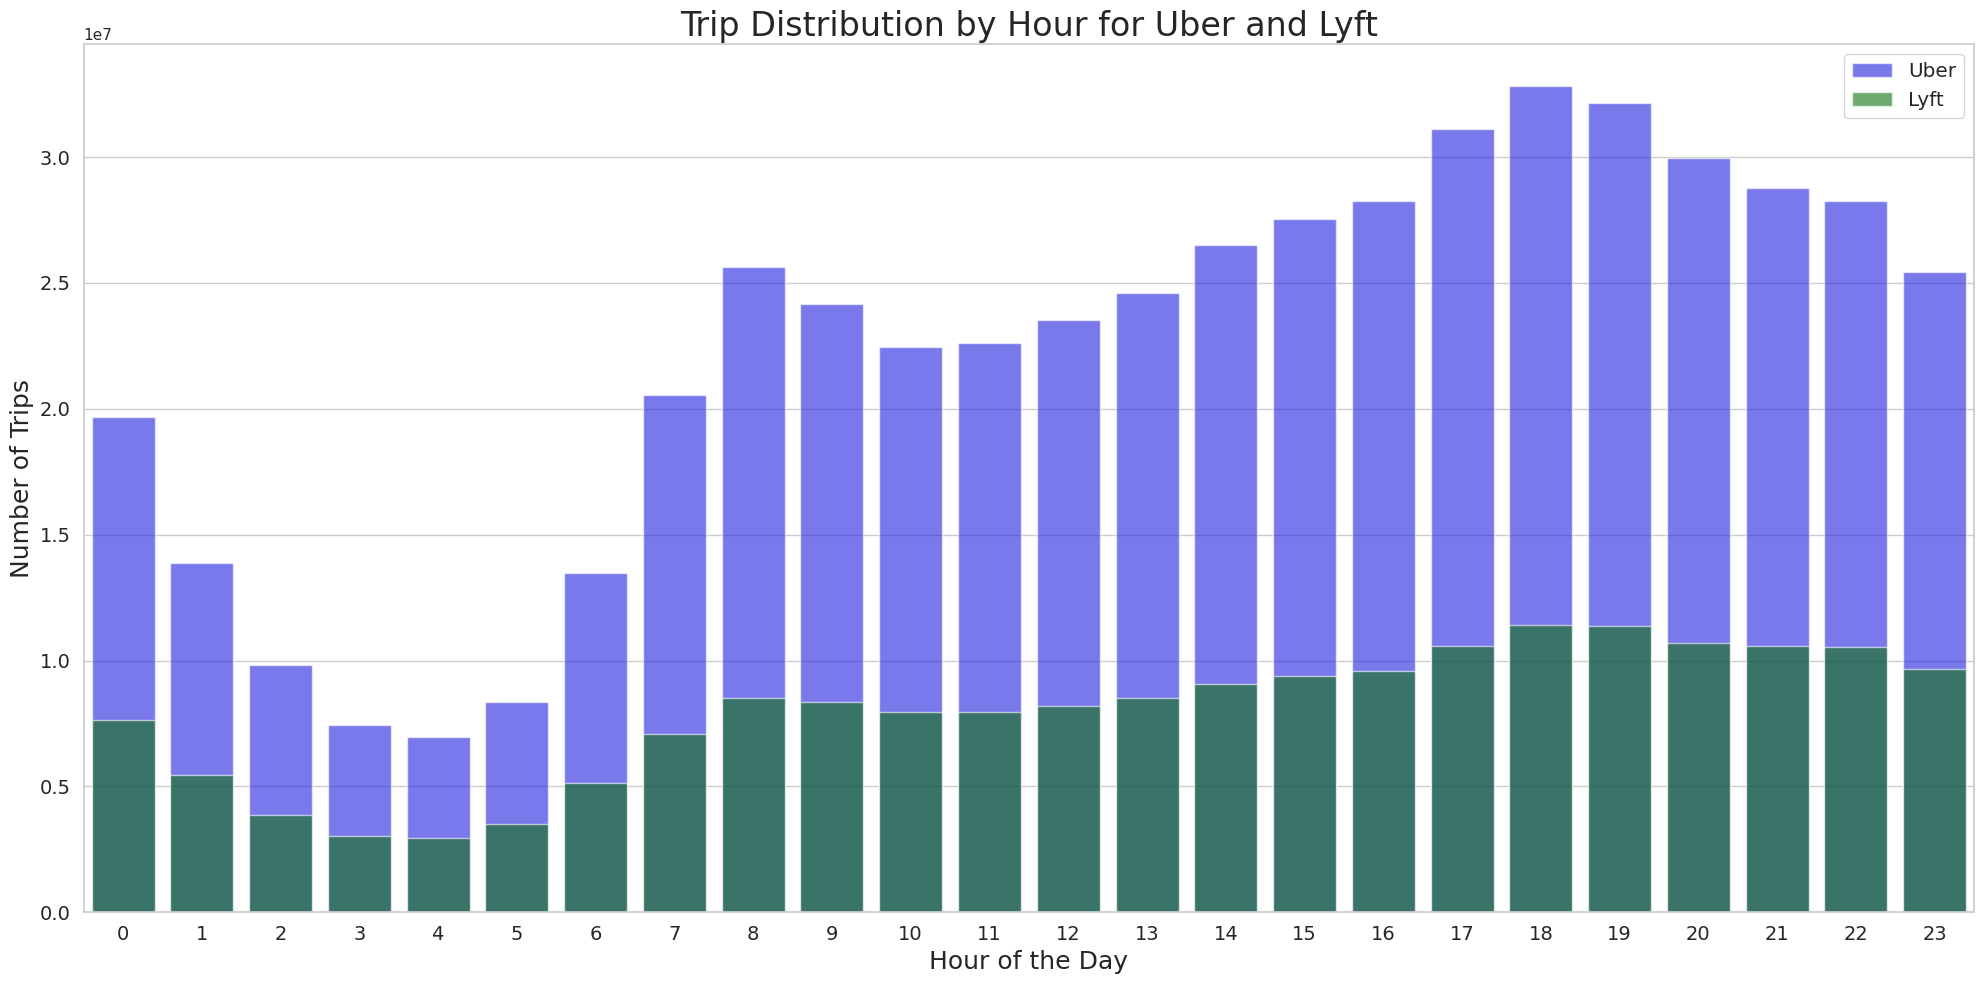

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Group by 'pickup_hour' and 'company', then count trips
trip_distribution_hour_company = tripdata_df.groupBy("pickup_hour", "company").agg(F.count("*").alias("trip_count"))

# Convert to Pandas DataFrame
pandas_trip_distribution = trip_distribution_hour_company.toPandas()

# Filter the DataFrame for only Uber and Lyft
pandas_trip_distribution = pandas_trip_distribution[pandas_trip_distribution['company'].isin(["Uber", "Lyft"])]

# Plotting
plt.figure(figsize=(20, 10))

# Create a bar plot for Uber
sns.barplot(data=pandas_trip_distribution[pandas_trip_distribution['company'] == "Uber"], 
            x='pickup_hour', y='trip_count', color='blue', label='Uber', alpha=0.6)

# Overlay a bar plot for Lyft
sns.barplot(data=pandas_trip_distribution[pandas_trip_distribution['company'] == "Lyft"], 
            x='pickup_hour', y='trip_count', color='green', label='Lyft', alpha=0.6)

plt.title('Trip Distribution by Hour for Uber and Lyft', fontsize=24)
plt.xlabel('Hour of the Day', fontsize=18)
plt.ylabel('Number of Trips', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize='large')

plt.tight_layout()
plt.show()


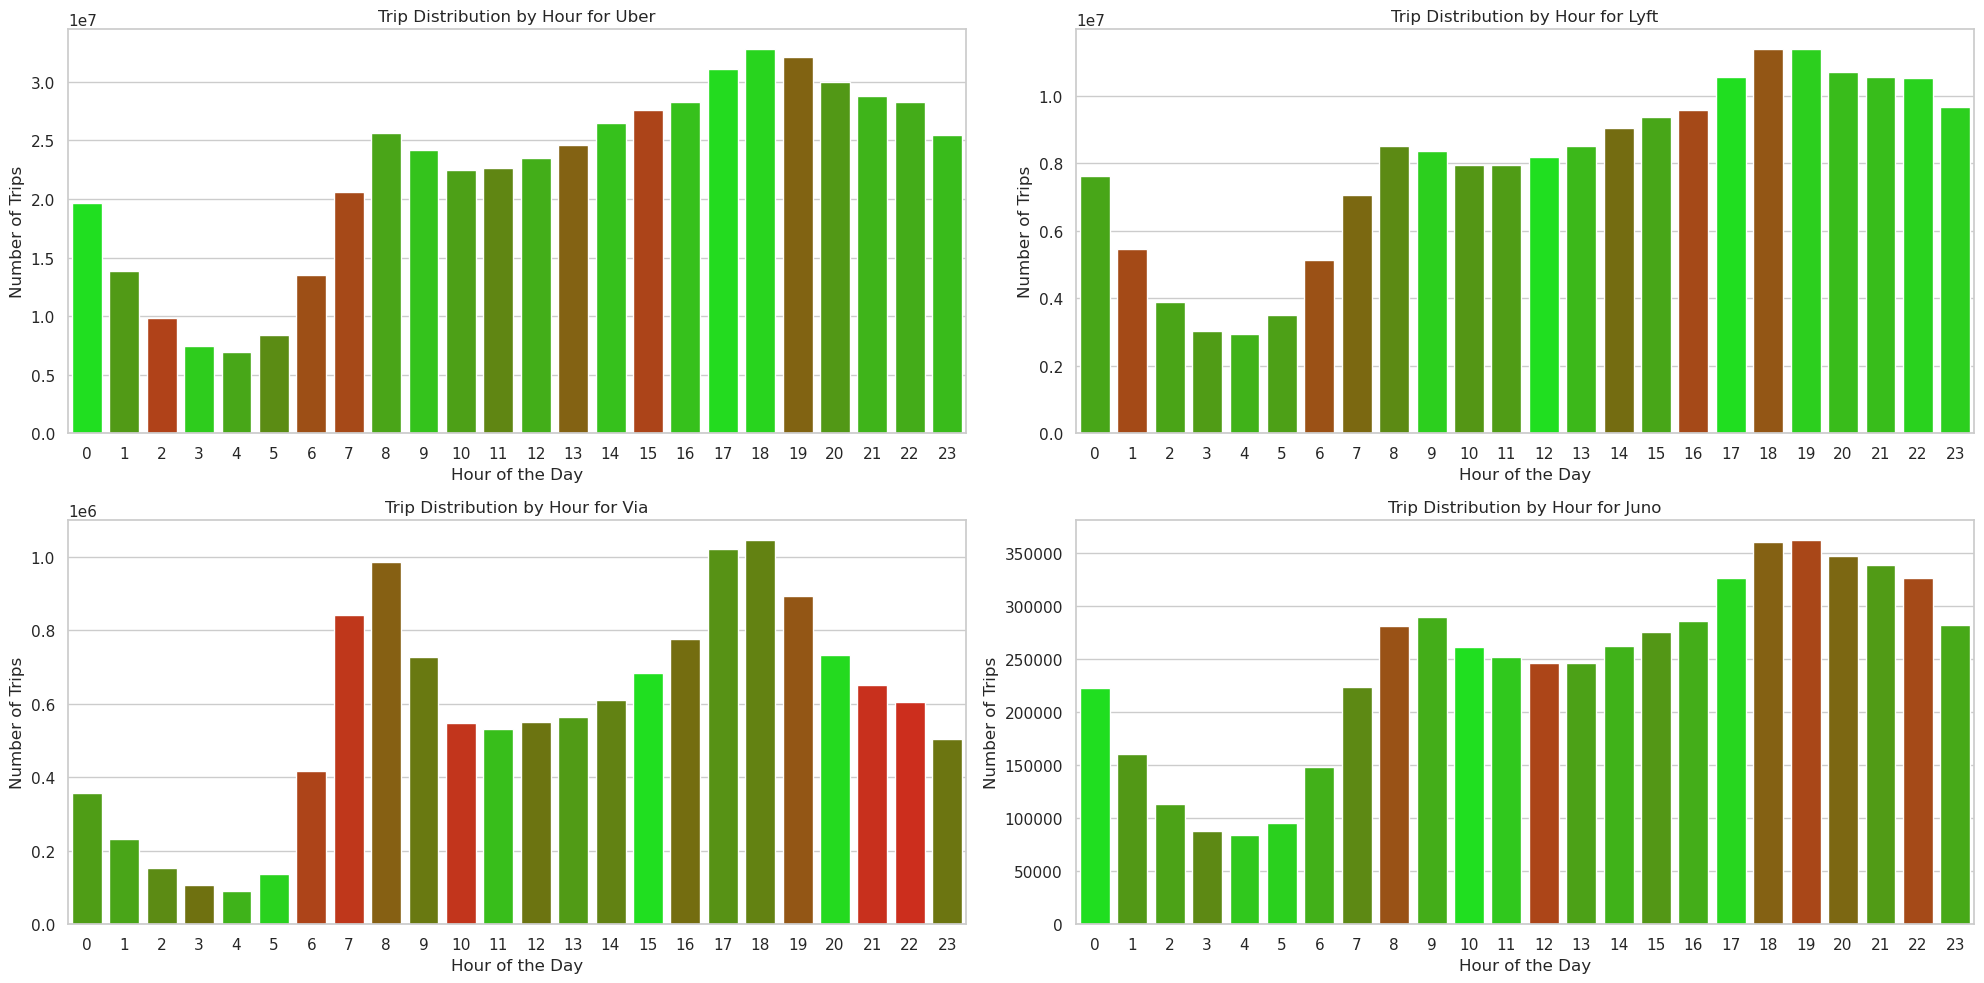

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors


# Group by 'pickup_hour' and 'company', then count trips
trip_distribution_hour_company = tripdata_df.groupBy("pickup_hour", "company").agg(F.count("*").alias("trip_count"))

# Convert to Pandas DataFrame
pandas_trip_distribution = trip_distribution_hour_company.toPandas()

# Define the list of companies
companies = ["Uber", "Lyft", "Via", "Juno"]

# Plotting
plt.figure(figsize=(20, 10))

for i, company in enumerate(companies, 1):
    plt.subplot(2, 2, i)  # Layout for 4 plots
    company_data = pandas_trip_distribution[pandas_trip_distribution['company'] == company]

    # Find the maximum trip count for the gradient
    max_trip_count = company_data['trip_count'].max()

    # Compute the color for each bar
    colors = [mcolors.to_hex((1 - x/max_trip_count, x/max_trip_count, 0)) for x in company_data['trip_count']]

    sns.barplot(data=company_data, x='pickup_hour', y='trip_count', palette=colors)
    plt.title(f'Trip Distribution by Hour for {company}')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Trips')

plt.tight_layout()
plt.show()


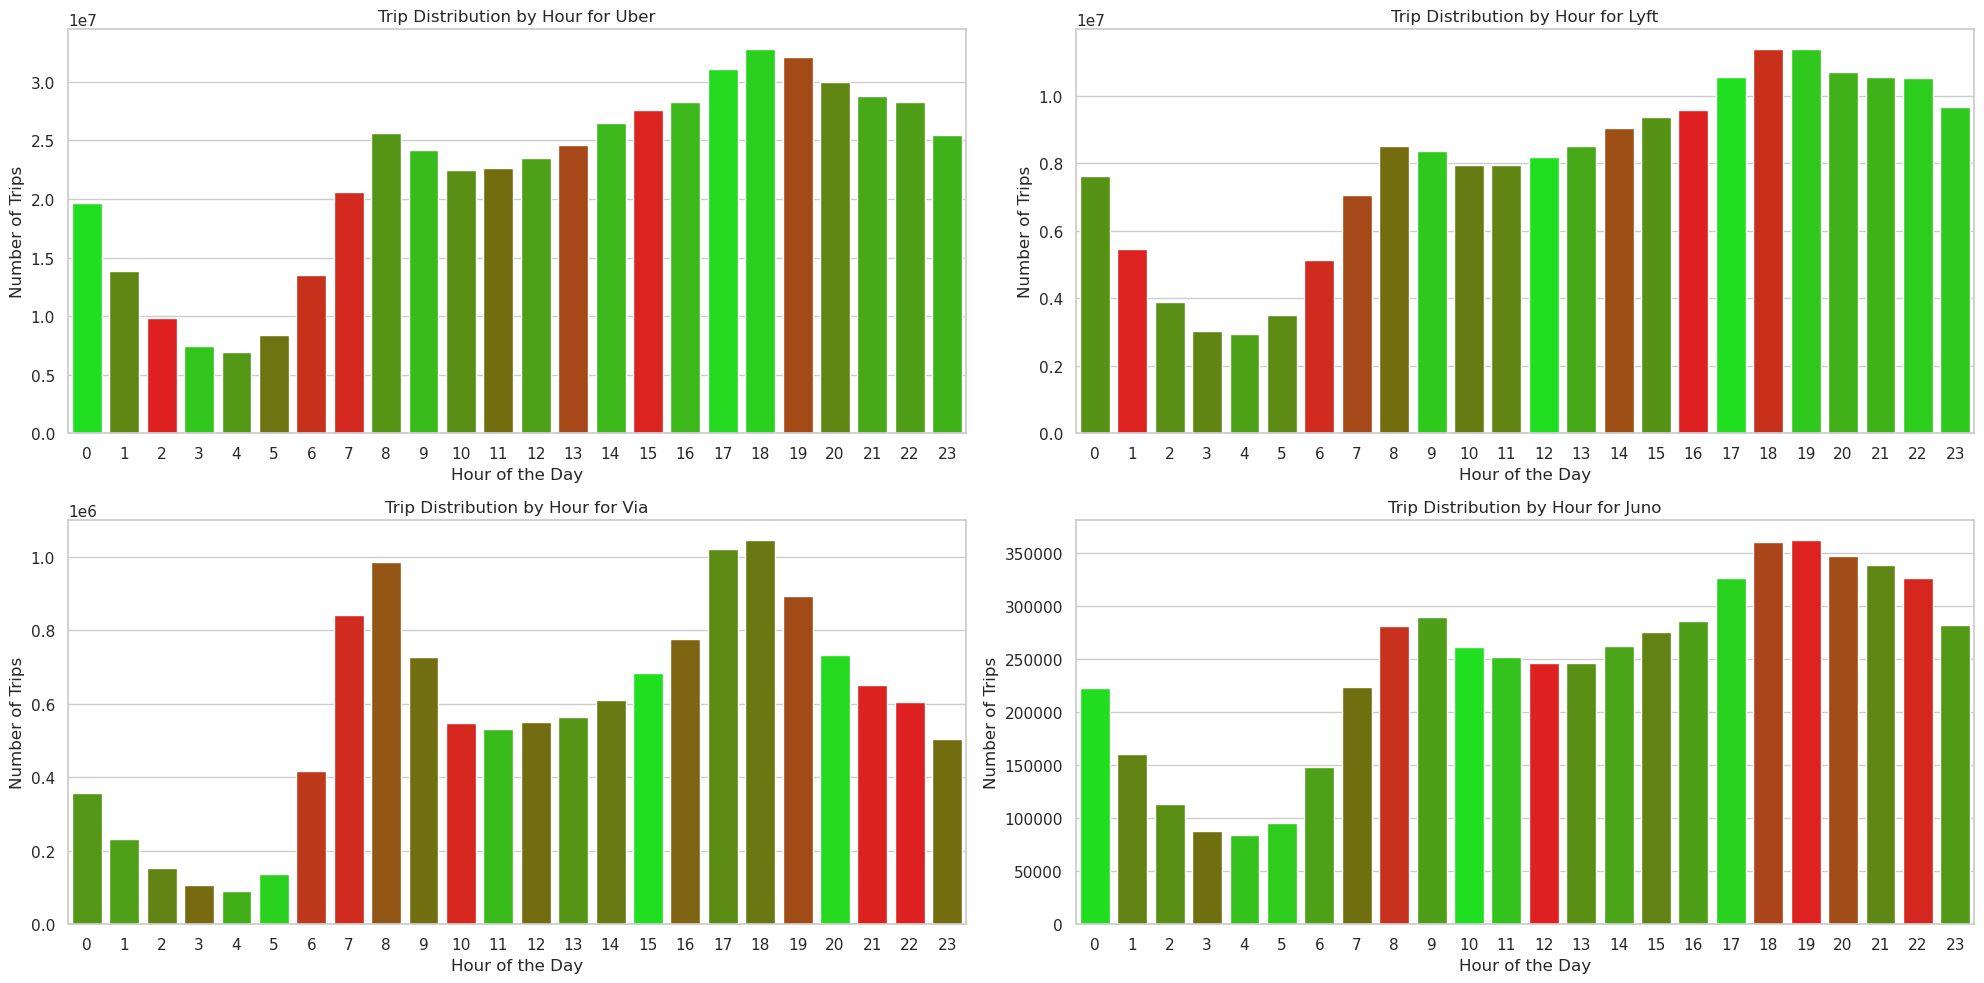

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors


# Group by 'pickup_hour' and 'company', then count trips
trip_distribution_hour_company = tripdata_df.groupBy("pickup_hour", "company").agg(F.count("*").alias("trip_count"))

# Convert to Pandas DataFrame
pandas_trip_distribution = trip_distribution_hour_company.toPandas()

# Define the list of companies
companies = ["Uber", "Lyft", "Via", "Juno"]



# Plotting
plt.figure(figsize=(20, 10))

for i, company in enumerate(companies, 1):
    plt.subplot(2, 2, i)  # Layout for 4 plots
    company_data = pandas_trip_distribution[pandas_trip_distribution['company'] == company]

    # Find the maximum and minimum trip count for each company
    max_trip_count = company_data['trip_count'].max()
    min_trip_count = company_data['trip_count'].min()

    # Normalize the trip counts between 0 and 1 for color mapping
    normalized_trip_count = (company_data['trip_count'] - min_trip_count) / (max_trip_count - min_trip_count)

    # Compute the color for each bar
    colors = [mcolors.to_hex((1 - x, x, 0)) for x in normalized_trip_count]

    sns.barplot(data=company_data, x='pickup_hour', y='trip_count', palette=colors)
    plt.title(f'Trip Distribution by Hour for {company}')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Trips')

plt.tight_layout()
plt.show()


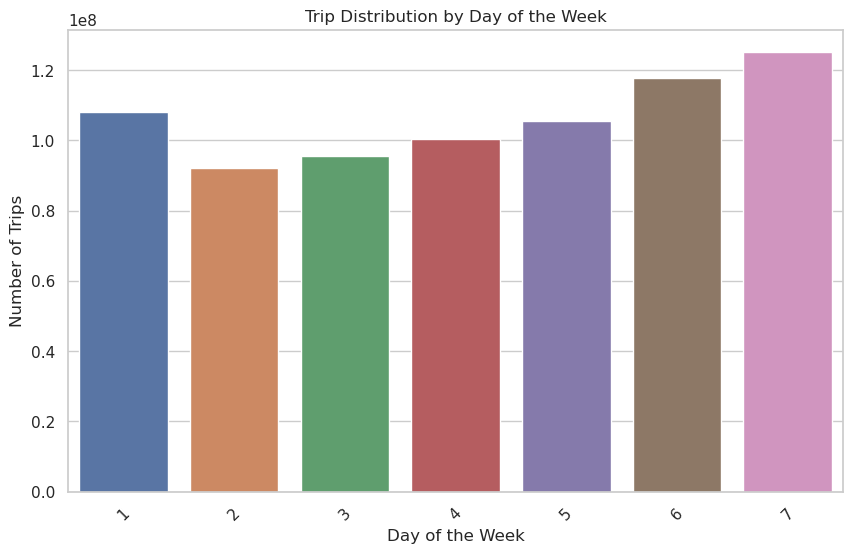

In [12]:
#Trip Distribution by Day of the Week



# Group by 'pickup_day_of_week' and count trips
trip_distribution_weekday = tripdata_df.groupBy("pickup_day_of_week").agg(F.count("*").alias("trip_count"))

# Convert to Pandas DataFrame
pandas_trip_distribution_weekday = trip_distribution_weekday.toPandas()




# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="pickup_day_of_week", y="trip_count", data=pandas_trip_distribution_weekday)
plt.title('Trip Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)  # Adjust depending on how days are encoded
plt.show()


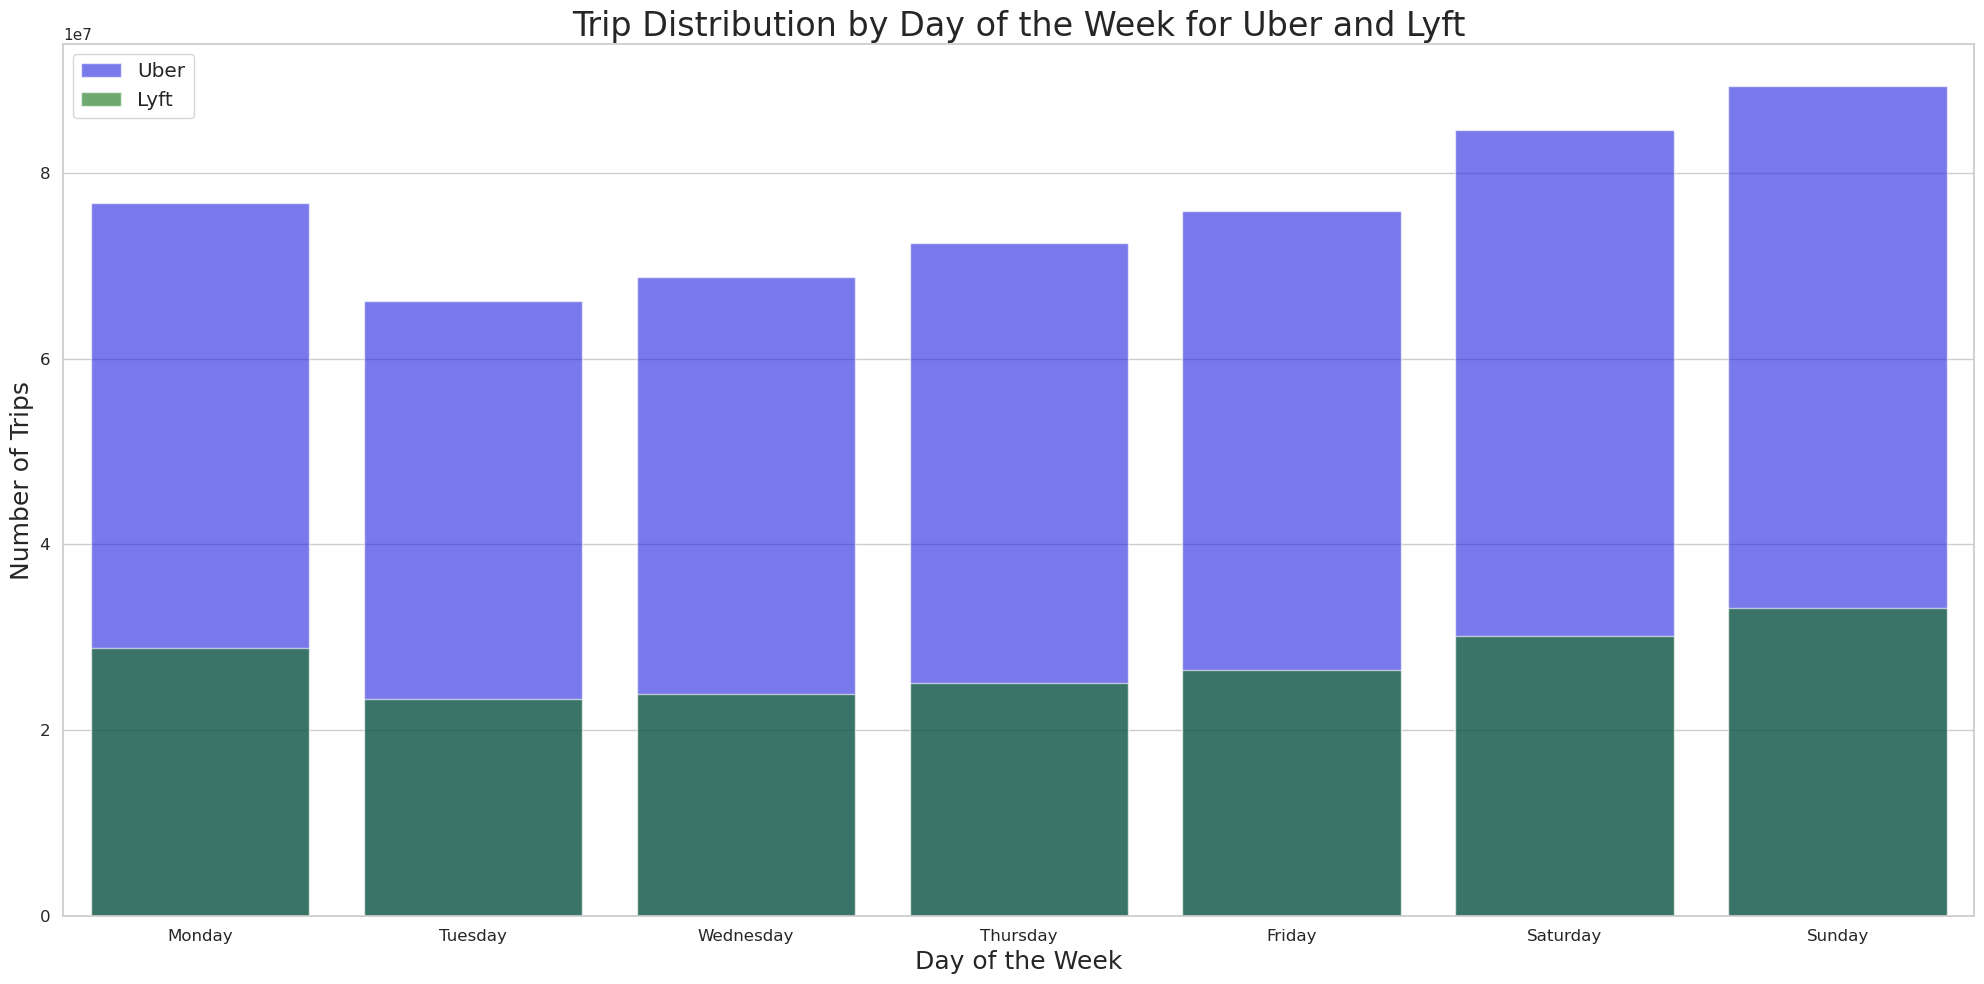

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Assuming tripdata_df already has the 'company' column as per your previous code

# Group by 'pickup_day_of_week' and 'company', then count trips
trip_distribution_weekday_company = tripdata_df.groupBy("pickup_day_of_week", "company").agg(F.count("*").alias("trip_count"))

# Convert to Pandas DataFrame
pandas_trip_distribution_weekday = trip_distribution_weekday_company.toPandas()

# Filter the DataFrame for only Uber and Lyft
uber_lyft_data = pandas_trip_distribution_weekday[pandas_trip_distribution_weekday['company'].isin(["Uber", "Lyft"])]

# Plotting Uber and Lyft on the same graph
plt.figure(figsize=(20, 10))

# Plot for Uber
sns.barplot(data=uber_lyft_data[uber_lyft_data['company'] == "Uber"], 
            x='pickup_day_of_week', y='trip_count', color='blue', label='Uber', alpha=0.6)

# Overlay plot for Lyft
sns.barplot(data=uber_lyft_data[uber_lyft_data['company'] == "Lyft"], 
            x='pickup_day_of_week', y='trip_count', color='green', label='Lyft', alpha=0.6)

plt.title('Trip Distribution by Day of the Week for Uber and Lyft', fontsize=24)
plt.xlabel('Day of the Week', fontsize=18)
plt.ylabel('Number of Trips', fontsize=18)

# Mapping 1-7 to days of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(ticks=range(0, 7), labels=days_of_week, fontsize=12) # Adjust the ticks

plt.yticks(fontsize=12)
plt.legend(fontsize='large')

plt.tight_layout()
plt.show()



In [21]:
tripdata_df.printSchema()

# Calculate the sum of the column
tripdata_df.select("shared_match_flag").filter(col("shared_match_flag") == 1).show()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: integer (nullable = true)
 |-- shared_match_flag: integer (nullable = true)
 |-- access_a_ride_flag: integer (nullable = true)
 |-- wav_match_flag: integer (nullable = true)
 |-- wait_time: long (nullable = true)
 |-- request_time_of_day: string (nullable = true)
 |-- request_hour: integer (nullable = true)
 |-- request_day_of_week: integer (nullable = true)
 |-- request_month: integer (nullable = true)

+-----------------+
|shared_match_flag|
+-----------------+
+-----------------+



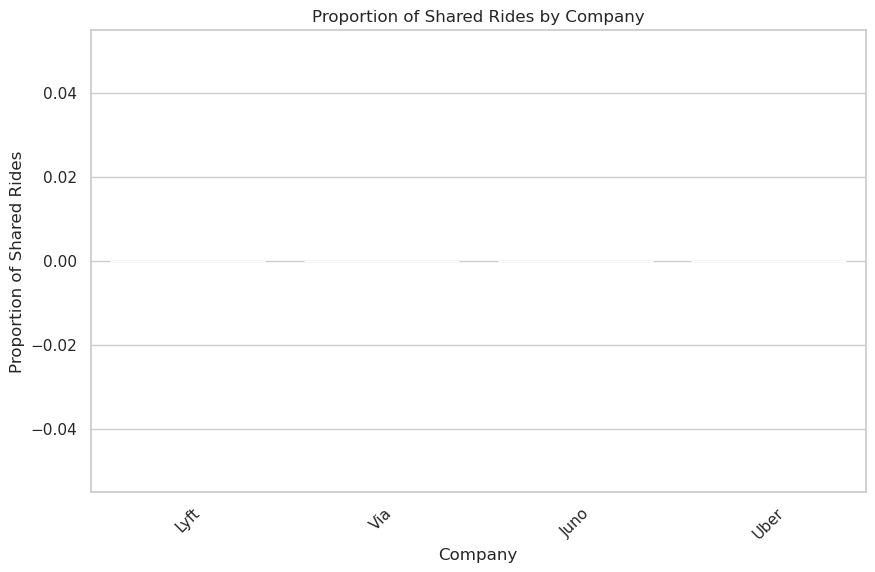

In [13]:
# Group by 'company' and calculate the proportion of shared rides
shared_rides_by_company = tripdata_df.groupBy("company").agg(
    (F.sum("shared_match_flag") / F.count("*")).alias("shared_ride_proportion")
)

# Convert to Pandas DataFrame
pandas_shared_rides = shared_rides_by_company.toPandas()




# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="company", y="shared_ride_proportion", data=pandas_shared_rides)
plt.title('Proportion of Shared Rides by Company')
plt.xlabel('Company')
plt.ylabel('Proportion of Shared Rides')
plt.xticks(rotation=45)
plt.show()


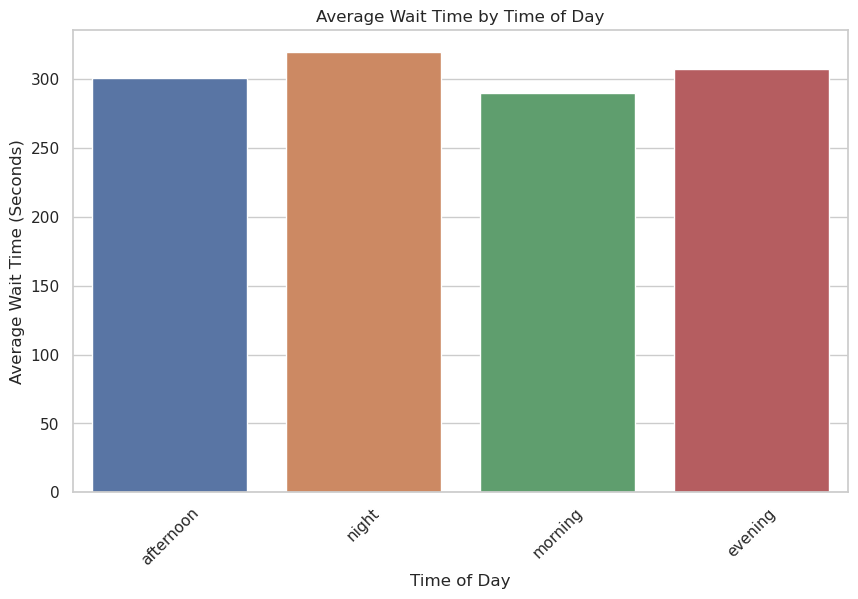

In [22]:
#Average Wait Times by Time of Day


# Group by 'pickup_time_of_day' and calculate average wait time
avg_wait_time_by_time_of_day = tripdata_df.groupBy("pickup_time_of_day").agg(
    F.avg("wait_time").alias("avg_wait_time")
)

# Convert to Pandas DataFrame
pandas_avg_wait_time = avg_wait_time_by_time_of_day.toPandas()





# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="pickup_time_of_day", y="avg_wait_time", data=pandas_avg_wait_time)
plt.title('Average Wait Time by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Wait Time (Seconds)')
plt.xticks(rotation=45)
plt.show()
